# Total variation in-painting



## Grayscale Images

A grayscale image is represented as an $m \times n$ matrix of intensities
$U^\mathrm{orig}$ (typically between the values $0$ and $255$).
We are given the values $U^\mathrm{orig}_{ij}$, for $(i,j) \in \mathcal K$, where
$\mathcal K \subset \{1,\ldots, m\} \times \{1, \ldots, n\}$ is the set of indices
corresponding to known pixel values.
Our job is to *in-paint* the image by guessing the missing pixel values,
*i.e.*, those with indices not in $\mathcal K$.
The reconstructed image will be represented by $U \in {\bf R}^{m \times n}$,
where $U$ matches the known pixels, *i.e.*,
$U_{ij} = U^\mathrm{orig}_{ij}$ for $(i,j) \in \mathcal K$.

The reconstruction $U$ is found by minimizing the total variation of $U$,
subject to matching the known pixel values. We will use the $\ell_2$ total
variation, defined as
$$\mathop{\bf tv}(U) =
\sum_{i=1}^{m-1} \sum_{j=1}^{n-1}
\left\| \left[ \begin{array}{c}
 U_{i+1,j}-U_{ij}\\ U_{i,j+1}-U_{ij} \end{array} \right] \right\|_2.$$
Note that the norm of the discretized gradient is *not* squared.


Based on a tutorial from https://www.cvxpy.org

We load the original image and the corrupted image and construct the Known matrix. Both images are displayed below. The corrupted image has the missing pixels whited out.

In [5]:
from google.colab import files
uploaded = files.upload()

for name, data in uploaded.items():
  with open(name, 'wb') as f:
    f.write(data)
    print ('saved file', name)

Saving lena256.png to lena256.png
Saving lena256_corrupted.png to lena256_corrupted.png
Saving lena256color.tiff to lena256color.tiff
Saving simple.png to simple.png
saved file lena256.png
saved file lena256_corrupted.png
saved file lena256color.tiff
saved file simple.png


(1, 1)
(9, 3)


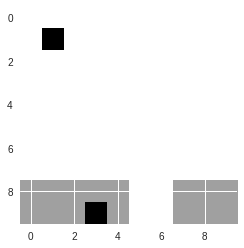

In [6]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

# Load the images.
orig_img = Image.open("simple.png")

# Convert to arrays.
Uorig = np.array(orig_img)
Uorig = Uorig[:,:,0]
rows, cols = Uorig.shape

# Known is 1 if the pixel is known,
# 0 if the pixel was corrupted.
Known = np.zeros((rows, cols))
for i in range(rows):
    for j in range(cols):
        #In "simple.png", an unknown pixel is marked as black
            if Uorig[i, j] != 0:
                Known[i, j] = 1
            else:
                print((i,j))

%matplotlib inline
plt.imshow(orig_img);


We use the solver SCS, which finds the optimal value in a few seconds. The solvers ECOS and CVXOPT take much longer to solve this large problem; the exact amount depends on your machine.
To describe the total variation objective, we need to understand the cvxpy syntax and limitations.
In CVXPY,  every cvx problem needs to be defined using basic operators, functions, and their combinations. 
for a list, see:
(https://www.cvxpy.org/tutorial/functions/index.html#functions)

Complete the problem objective using "norm" function and "vstack" function.




In [0]:
# Recover the original image using total variation in-painting.
from cvxpy import *
# variable for each pixel
U = Variable(shape=(rows, cols))
obj= 0
# add total variation objective explicitly (don't use minimize or TV functions)
diffs = []
diffs += [
    U[0:rows-1, 1:cols] - U[0:rows-1, 0:cols-1],
    U[1:rows, 0:cols-1] - U[0:rows-1, 0:cols-1],
        ]
length = diffs[0].shape[0]*diffs[1].shape[1]
stacked = np.vstack([np.reshape(diff, (1, length)) for diff in diffs])
obj = np.sum(np.norm(stacked, p=2, axis=0))

obj = Minimize(obj)
# add constraints using "multiply" function
constraints = [multiply(Known, U) == multiply(Known, Ucorr)]
prob = Problem(obj, constraints)
# Use SCS to solve the problem.
prob.solve(solver=SCS)

fig, ax = plt.subplots(1, 2,figsize=(10, 5))
# Display the in-painted image.
img_rec = Image.fromarray(U.value)
ax[0].imshow(img_rec);
ax[0].set_title("In-Painted Image")
ax[0].axis('off')

img_diff = Image.fromarray(np.abs(Uorig - U.value))
ax[1].imshow(img_diff);
ax[1].set_title("Difference Image")
ax[1].axis('off');

ValueError: ignored

In [8]:
!pip install cvxpy

    100% |████████████████████████████████| 901kB 6.6MB/s 
    100% |████████████████████████████████| 143kB 6.7MB/s 
    100% |████████████████████████████████| 122kB 7.0MB/s 
    100% |████████████████████████████████| 143kB 8.1MB/s 
    100% |████████████████████████████████| 1.4MB 5.9MB/s 
    100% |████████████████████████████████| 153kB 14.2MB/s 
  Running setup.py bdist_wheel for cvxpy ... done
  Stored in directory: /content/.cache/pip/wheels/6d/78/df/bd8d02476516cf184699705248d001a806c220add5e3994caa
  Running setup.py bdist_wheel for ecos ... done
  Stored in directory: /content/.cache/pip/wheels/50/91/1b/568de3c087b3399b03d130e71b1fd048ec072c45f72b6b6e9a
  Running setup.py bdist_wheel for scs ... done
  Stored in directory: /content/.cache/pip/wheels/ff/f0/aa/530ccd478d7d9900b4e9ef5bc5a39e895ce110bed3d3ac653e
  Running setup.py bdist_wheel for multiprocess ... done
  Stored in directory: /content/.cache/pip/wheels/8b/36/e5/96614ab62baf927e9bc06889ea794a8e87552b84bb6bf65e3e
 

Here's an example for a larger image, Lena:

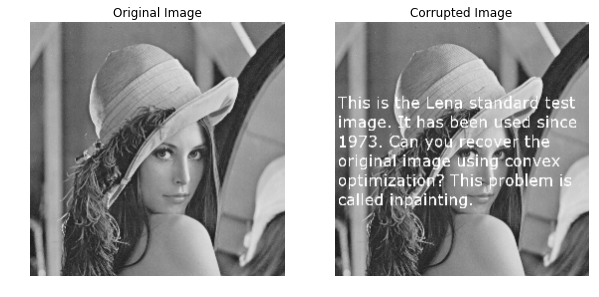

In [0]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

# Load the images.
orig_img = Image.open("data/lena256.png")
corr_img = Image.open("data/lena256_corrupted.png")


# Convert to arrays.
Uorig = np.array(orig_img)
Ucorr = np.array(corr_img)
rows, cols = Uorig.shape

%matplotlib inline
fig, ax = plt.subplots(1, 2,figsize=(10, 5))
ax[0].imshow(orig_img);
ax[0].set_title("Original Image")
ax[0].axis('off')
ax[1].imshow(corr_img);
ax[1].set_title("Corrupted Image")
ax[1].axis('off');

Now, instead of explicitly describing the total variation in-painting problem, we'll use a function directly expresssing that.

In [0]:

# Known is 1 if the pixel is known,
# 0 if the pixel was corrupted.
Known = np.zeros((rows, cols))
for i in range(rows):
    #your code...constract Know


In [0]:
# Recover the original image using total variation in-painting.
from cvxpy import *
U = Variable(shape=(rows, cols))
#fill objective using "tv" function
obj = # fill your code (this time u can use The Minimize or tv functinos ))
#fill constraints
constraints = ...
prob = Problem(obj, constraints)
# Use SCS to solve the problem.
prob.solve(verbose=True, solver=SCS)

----------------------------------------------------------------------------
	SCS v2.0.2 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012-2017
----------------------------------------------------------------------------
Lin-sys: sparse-indirect, nnz in A = 385588, CG tol ~ 1/iter^(2.00)
eps = 1.00e-05, alpha = 1.50, max_iters = 5000, normalize = 1, scale = 1.00
acceleration_lookback = 20, rho_x = 1.00e-03
Variables n = 130561, constraints m = 260611
Cones:	primal zero / dual free vars: 65536
	soc vars: 195075, soc blks: 65025
Setup time: 2.92e-02s
----------------------------------------------------------------------------
 Iter | pri res | dua res | rel gap | pri obj | dua obj | kap/tau | time (s)
----------------------------------------------------------------------------


After solving the problem, the in-painted image is stored in `U.value`. We display the in-painted image and the intensity difference between the original and in-painted images. The intensity difference is magnified by a factor of 10 so it is more visible.

In [0]:
fig, ax = plt.subplots(1, 2,figsize=(10, 5))
# Display the in-painted image.
img_rec = Image.fromarray(U.value)
ax[0].imshow(img_rec);
ax[0].set_title("In-Painted Image")
ax[0].axis('off')

img_diff = Image.fromarray(10*np.abs(Uorig - U.value))
ax[1].imshow(img_diff);
ax[1].set_title("Difference Image")
ax[1].axis('off');

# Color Images

For color images, the in-painting problem is similar to the grayscale case. A color image is represented as an $m \times n \times 3$ matrix of RGB values
$U^\mathrm{orig}$ (typically between the values $0$ and $255$).
We are given the pixels $U^\mathrm{orig}_{ij}$, for $(i,j) \in \mathcal K$, where
$\mathcal K \subset \{1,\ldots, m\} \times \{1, \ldots, n\}$ is the set of indices
corresponding to known pixels. Each pixel $U^\mathrm{orig}_{ij}$ is a vector in ${\bf R}^3$ of RGB values.
Our job is to *in-paint* the image by guessing the missing pixels,
*i.e.*, those with indices not in $\mathcal K$.
The reconstructed image will be represented by $U \in {\bf R}^{m \times n \times 3}$,
where $U$ matches the known pixels, *i.e.*,
$U_{ij} = U^\mathrm{orig}_{ij}$ for $(i,j) \in \mathcal K$.

The reconstruction $U$ is found by minimizing the total variation of $U$,
subject to matching the known pixel values. We will use the $\ell_2$ total
variation, defined as
$$\mathop{\bf tv}(U) =
\sum_{i=1}^{m-1} \sum_{j=1}^{n-1}
\left\| \left[ \begin{array}{c}
 U_{i+1,j}-U_{ij}\\ 
 U_{i,j+1}-U_{ij} 
 \end{array} \right] \right\|_2.$$
Note that the norm of the discretized gradient is *not* squared.

We load the original image and construct the Known matrix by randomly selecting 30% of the pixels to keep and discarding the others. The original and corrupted images are displayed below. The corrupted image has the missing pixels blacked out.

In [0]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

np.random.seed(1)
# Load the images.
orig_img = Image.open("data/lena256color.tiff")

# Convert to arrays.
Uorig = np.array(orig_img)
rows, cols, colors = Uorig.shape

# Known is 1 if the pixel is known,
# 0 if the pixel was corrupted.
# The Known matrix is initialized randomly.
Known =  # fill your code
            
Ucorr = # fill your code


corr_img = Image.fromarray(np.uint8(Ucorr))

# Display the images.
%matplotlib inline
fig, ax = plt.subplots(1, 2,figsize=(10, 5))
ax[0].imshow(orig_img);
ax[0].set_title("Original Image")
ax[0].axis('off')
ax[1].imshow(corr_img);
ax[1].set_title("Corrupted Image")
ax[1].axis('off');

We express the total variation color in-painting problem in CVXPY using three matrix variables (one for the red values, one for the blue values, and one for the green values). Again we use the solver SCS. The solvers ECOS and CVXOPT don't scale to this large problem.
Naturally, this problem takes much more time to solve than the previous one.

In [0]:
# Recover the original image using total variation in-painting.
from cvxpy import *
variables = []
constraints = []
#construct problem constraints
for i in range(colors):
#add constratins for that color channel (r, g or b)

# use Problem, solve, Minimize and tv -- to solve this



After solving the problem, the RGB values of the in-painted image are stored in the value fields of the three variables. We display the in-painted image and the difference in RGB values at each pixel of the original and in-painted image. Though the in-painted image looks almost identical to the original image, you can see that many of the RGB values differ.

In [0]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline

# Load variable values into a single array.
rec_arr = np.zeros((rows, cols, colors), dtype=np.uint8)
for i in range( # your code ):
    rec_arr[:, :, i] =  # your code 

fig, ax = plt.subplots(1, 2,figsize=(10, 5))
# Display the in-painted image.
img_rec = Image.fromarray(rec_arr)
ax[0].imshow(img_rec);
ax[0].set_title("In-Painted Image")
ax[0].axis('off')

img_diff = Image.fromarray(np.abs(Uorig - rec_arr))
ax[1].imshow(img_diff);
ax[1].set_title("Difference Image")
ax[1].axis('off');